### Qual o problema ? 
- Possuímos a seguinte equação matemática
![title](image/equacao.png)
- Quanto maior o resultado dessa função, melhor para nós.
- Queremos descobrir qual valor de **X**  gera um resultado maior? 
- Não temos a resposta exata, ou seja, na teoria não sabemos o quanto essa função pode ser maximizada, portanto quanto maior o valor que conseguimos melhor.

### Representação 
- O domínio do problema se dá em um intervalo de [0, 1]
- X pode assumir qualquer valor dentro desse domínio

### Objetivo
- **Maximizar** o resultado da equação através do maior valor possível de X.
- O melhor valor será definido por aquele que tiver o maior resultado final dentre todas as soluções encontradas

## Codificando
- Vamos começar com a importação das bibliotecas usadas.

In [25]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Criação da função de custo / avaliação
- É o coração dos algoritmos de otimização
- A função de custo é onde a avaliação do algoritmo vai acontecer de fato
- Nesse caso a função de custo é dada simplesmente pelo resultado da equação que deve ser maximizado

In [26]:
def funcao_custo(x):
    custo = 2 ** (-2 *((((x-0.1) / 0.9)) ** 2)) * ((math.sin(5*math.pi*x)) ** 6)
    return custo

### Exibindo os resultados
- A função de plotar busca gera um gráfico simples que mostra a variação dos resultados da função de custo x número de iterações do algoritmo
- A função de exibir sumário por outro lado nos exibe na tela o sumário de resultados do algoritmo.

In [27]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(t, resultados)
    plt.show()

In [28]:
def exibir_sumario_resultados(solucao, custos):
    print('Valor X que gerou melhor resultado:', solucao[custos.index(max(custos))])
    print('Maior custo:', max(custos))
    print('Média de custos:', np.mean(custos))
    print('Desvio padrão:', np.std(custos))
    plotar_busca(custos)

### Pegando os vizinhos
- A função **get_vizinhos** é usada para pegar os vizinhos de cada dimensão da minha variável, no nosso caso temos uma única dimensão, que é o valor da variável X.
- Sendo assim vamos pegar os dois vizinhos possíveis do nosso X, sendo o valor superior e inferior ao X atual, configurando assim os movimentos que ele poderá fazer pelo espaço de busca em cada iteração. 
- O vizinho nada mais é que uma **perturbação** no valor inicial, pode se um valor constante ou alguma outra formula, como a gaussiana.
- Nesse caso, optei por usar uma constante para gerar a perturbação. A constante conseguiu explorar bem o espaço de busca, porém a sua grandeza foi escolhida baseada nos testes de desempenho de cada algoritmo.
- Na nossa função de get_vizinhos, nós temos também um parâmetro não obrigatório de taxa de aprendizado, que pode ser usado para reduzir o valor da constante baseado nas iterações do algoritmo, fazendo com que os passos dados na nossa busca sejam menores conforme as iterações.
- Isso faz com que nosso passo seja maior a princípio, fazendo com que a exploração pelo espaço de busca comece de forma mais rápida, porém ele desacelera com o passar do tempo, diminuindo o risco de pularmos nosso máximo global por estar com um "passo" muito grande.
- Por fim nós também adicionamos operadores condicionais para garantir que nossos vizinhos sejam pontos menores que 1 e maiores que 0 (dentro do domínio)

In [29]:
def get_vizinhos(solucao, tx_aprendizado = 1):
    vizinhos = []
    constante = 0.005 / tx_aprendizado
    vizinho_superior = solucao + constante if solucao + constante < 1 else solucao
    vizinho_inferior = solucao - constante if solucao - constante > 0 else solucao
    
    vizinhos.append(vizinho_superior)
    vizinhos.append(vizinho_inferior)
    return vizinhos

### Pegando valor aleatório espaçado
- A função de **get_valor_aleatório** vai garantir que meus valores aleatórios tenham um espaço mínimo entre eles.
- Essa função é usada porque os algoritmos, principalmente o Hill Climbing, dependem de sua inicialização, pois iniciar em um ponto favorável pode gerar resultados consideravelmente melhores do que em um ponto não favorável.
- Com isso, damos maior capacidade de exploração no espaço de busca para algoritmos que são mais fortes na explotação, através de multiplas inicializações.
- Esse espaço mínimo foi definida por uma constante, sua grandeza deve ser de acordo com o tamanho do domínio do problema.

In [64]:
def get_valor_aleatorio(espaco, x=0):
    inicio = random.random()
    valor = []
    
    for i in espaco:
        diferenca = i - inicio
        if diferenca > 0.08 or diferenca < -0.08:
            valor.append(diferenca)

    if len(valor) == len(espaco) or x > 300:
        return inicio
    else:
        return get_valor_aleatorio(espaco, x = x + 1)

### Hill Climbing
- Função que vai fazer o cálculo do algoritmo de subida da encosta
- Os critérios de parada são:
    - Atingir 400 iterações
    - Ficar 20 iterações sem melhoria
    - Ter apenas vizinhos piores que a solução atual
- A ideia de parada no platô é valida caso nosso algoritmo fique preso em uma armadilha de "maximo local reto" como podemos ver na imagem, fazendo com que o algoritmo não tenha que ser executado pelo limite de 400 iterações.
- Claro que o parâmetro de platô também não pode ser muito pequeno, pois caso tenhamos caído em um "ombro (shoulder)" existe a esperança de melhoria
    
![title](image/hill-climbing.png)

- Não foi usado uma semente aleatória para não remover a propriedáde estocástica do algoritmo, principalmente pelo fato que foram realizadas diversas execuções

In [31]:
def hill_climbing(funcao_custo, solucao_inicial):
    solucao = solucao_inicial
    custos = []
    count = 1
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao, count)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo >= melhor:
                parar_no_plato = parar_no_plato + 1 if custo == melhor else 0
                melhor = custo
                solucao = vizinhos[i]

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            if parar_no_plato == 20: print('parada no platô')
            break

    return solucao, custos

## Execução e avaliação do Hill Climbing
- Possuímos aqui diversas formas de se inicializar e executar o algoritmo de subida da encosta para tentar buscar melhores resultados.
- Porém, não é interessante que a gente execute ele apenas uma vez, pois ele tem uma variação muito grande nos resultados, por depender muito da inicialização.
- Para tal, estou executando o algoritmo 30 vezes

### Inicialização aleatória
- Nessa primeira forma o algoritmo foi inicializado com um valor aleatório dentro do nosso domínio [0,1] pelas 30 iterações.

In [51]:
custos = []
solucao = []
espaco_solucao = []

for i in range(30):   
    solucao_subida_encosta = hill_climbing(funcao_custo, random.random())
    solucao.append(solucao_subida_encosta[0])
    custos.append(max(solucao_subida_encosta[1]))

Valor X que gerou melhor resultado: 0.10005579557820127
Maior custo: 0.9999976902599372
Média de custos: 0.43570719499879235
Desvio padrão: 0.3049853150296042


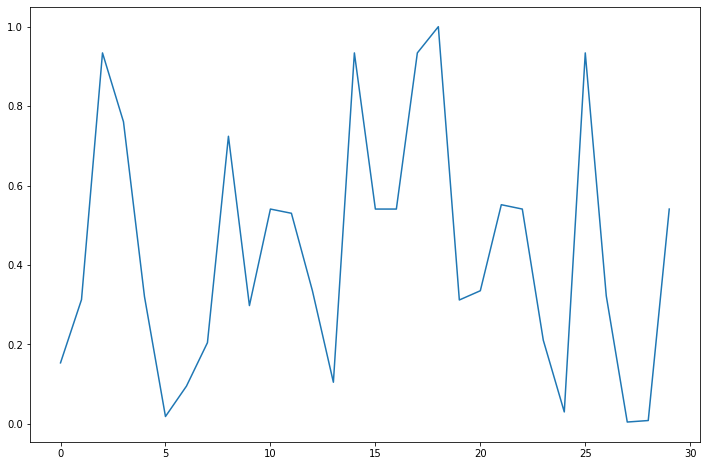

In [52]:
exibir_sumario_resultados(solucao, custos)

- Como podemos ver, conseguimos atingir o valor X de 0.1, chegando a um custo de 0.99.
- Porém fica claro no gráfico a enorme variáção dos resultados cada vez que o algoritmo é inicializado
- Isso se reflete obviamente nas médias e desvio padrão das 30 execuções, gerando um algoritmo bastante instável.

### Explorando o espaço de busca
- Usamos nossa função de pegar o valor aleatório para garantir um espaçamento na busca

In [65]:
custos = []
solucao = []
espaco_solucao = []

for i in range(30):  
    espaco_solucao.append(get_valor_aleatorio(espaco_solucao))
    solucao_subida_encosta = hill_climbing(funcao_custo, espaco_solucao[len(espaco_solucao) - 1])
    solucao.append(solucao_subida_encosta[0])
    custos.append(max(solucao_subida_encosta[1]))
print('Espaço de busca explorado:', espaco_solucao)

Espaço de busca explorado: [0.9849577441725336, 0.16164801161611586, 0.00443391384700953, 0.44158708358514087, 0.7721198971192463, 0.5774336176085821, 0.3158988070891784, 0.8857815610307219, 0.674677033496265, 0.20665129322851516, 0.9168095520730901, 0.469521530803515, 0.39826463521958, 0.758276848011451, 0.5609798603017612, 0.5357528789411027, 0.28630349496071905, 0.8960218388749056, 0.9532388302195494, 0.4217682665270265, 0.9590315681791048, 0.47546621111566234, 0.2783323194673749, 0.09037380139834628, 0.22580011692695434, 0.7667575618746872, 0.9255784985265904, 0.29247298137187494, 0.7141365736433644, 0.4135002845154856]


Valor X que gerou melhor resultado: 0.09954046806501295
Maior custo: 0.9998433374735568
Média de custos: 0.4212082307262926
Desvio padrão: 0.3136220451628754


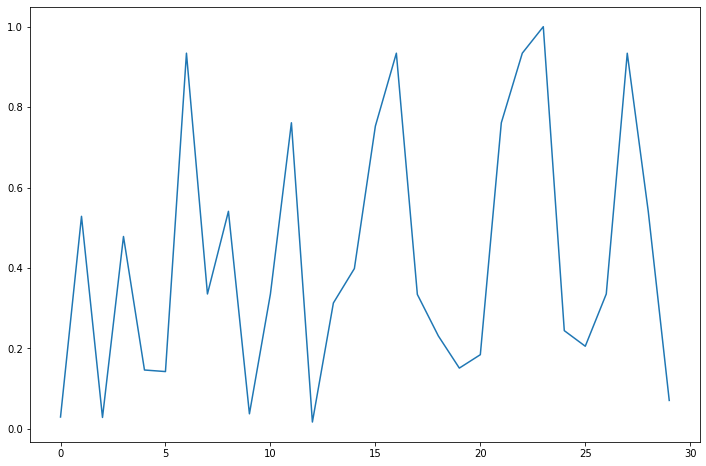

In [66]:
exibir_sumario_resultados(solucao, custos)

- Como pudemos ver os resultados não mudaram muito em relação à versão anterior, possivelmente se tivéssemos um espaço de busca maior do que [0,1] essa abordagem seria mais impactante para os resultados

### Simulated annealing
Recozimento simulado é inspirado em um fenômeno da física, onde se esquenta um metal ou vidro até quase ele se liquefazer e depois se esfria devagar, para que os átomos percam a vibração aos poucos e o material fique rígido

- A diferença dele para o Hill Climbing é que ele tem uma probabilidade P de aceitar valores negativos
- Quanto mais no início do algoritmo, maior a sua chance de aceitar um valor negativo

### Probabilidade
- A probabilidade do simulated annealing é dada pela função exponencial exp(x)
- Nessa função, elevamos o número de euler ~2.7 à um valor de x.
- O X no nosso caso é o resultado da subtração entre o novo custo e o custo anterior divido pela temperatura: (x' - x) / T
- A temperatura vai diminuindo gradativamente, limitando nossas interações e garantindo que a probabilidade de se aceitar valores negativos também diminua

### Problemas encontrados na abordagem
- Foi encontrado um problema relacionado ao valor da temperatura, que precisa ser normalizado, pois nesse caso estamos trabalhando com valores muito pequenos e uma temperatura sem ser normalizada gera valores sempre próximos a 100%, fazendo com que valores negativos sejam sempre aceitos

In [ ]:
def simulated_annealing(dominio, funcao_custo, temperatura = 10000.0, resfriamento = 0.95, passo = 1):
    # random.seed(a=0)
    solucao = random.random()
    custos = []
    count = 1
    parar_no_plato = 0

    while temperatura > 0.1:
        vizinhos = get_vizinhos(solucao, count)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            
            if parar_no_plato == 20:
                break

            custo = funcao_custo(vizinhos[i])
            probabilidade = pow(math.e, (-custo - melhor) / temperatura)
            
            if custo >= melhor or random.random() < probabilidade:
                parar_no_plato = parar_no_plato + 1 if custo == melhor else 0
                melhor = custo
                solucao = vizinhos[i]

        temperatura = temperatura * resfriamento

    return solucao, custos

In [ ]:
solucao_tempera_simulada = simulated_annealing([0, 1], funcao_custo)
custo_tempera_simulada = funcao_custo(solucao_tempera_simulada[0])

print('Menor custo', custo_tempera_simulada)
plotar_busca(solucao_tempera_simulada[1])

### Algoritmo genético
- Inspirados no evolucionismo, principalmente em seleção natural e combinação genética
- Escolhe os melhores indivíduos da população para reproduzir

### Mutação
- Processo aleatório que ocorre na população, mudando as características de um gene

In [ ]:
def mutacao(solucao):
    constante = 0.005

    if random.random() < 0.5:
        mutante = solucao - constante if solucao - constante > 0 else solucao
    else:
        mutante = solucao + constante if solucao + constante < 1 else solucao
    
    return mutante

### crossover 
- Técnica onde os indivíduos da população compartilham os genes, distribuindo as características entre eles

In [ ]:
def crossover(solucao1, solucao2):
    crossed = (solucao1 + solucao2) / 2
    return crossed

In [ ]:
def genetico(funcao_custo, tamanho_populacao = 50, p_mutacao = 0.2, elitismo = 0.2, geracoes=100):
    populacao = []
    for i in range(tamanho_populacao):
        populacao.append(random.random())
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        custos.sort(reverse=True)
        individuos_ordenados = [individuos for (custo, individuos) in custos]
        
        populacao = individuos_ordenados[0:numero_elitismo]
    
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, numero_elitismo)
                populacao.append(mutacao(individuos_ordenados[individuo_selecionado]))
            else:
                individuo1 = random.randint(0, numero_elitismo)
                individuo2 = random.randint(0, numero_elitismo)
                populacao.append(crossover(individuos_ordenados[individuo1], 
                                           individuos_ordenados[individuo2]))
    return custos[0][0], custos[0][1]

In [ ]:
melhor_custo, x = genetico(funcao_custo)
print(melhor_custo, x)

### Avaliação dos algoritmos
- Qual algoritmo teve os resultados melhores e os parâmetros e técnicas que foram aplicados para isso.